In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the ZIP file

Saving archive (43) (5).zip to archive (43) (5).zip


In [21]:
import zipfile
import os

zip_path = next(iter(uploaded))  # Gets the uploaded file name
extract_path = "unzipped_data"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
])

# Dataset from folder
dataset = datasets.ImageFolder(root=extract_path, transform=transform)

# Dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [23]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Path to your actual image folders
data_path = "/content/unzipped_data/images"

# Load the dataset
dataset = datasets.ImageFolder(data_path, transform=train_transform)

# Split into train/test (e.g., 80% train, 20% test)
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

# Class names
class_names = dataset.classes
print(class_names)
print(f"Training images: {len(train_data)}")
print(f"Testing images: {len(test_data)}")


['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']
Training images: 287
Testing images: 72


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
VGG19model = models.vgg19(pretrained=True)

In [26]:
# Freeze feature parameters
for param in VGG19model.parameters():
    param.requires_grad = False

In [27]:
torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, len(class_names)),  # Set the output layer to the number of classes
    nn.LogSoftmax(dim=1)
)

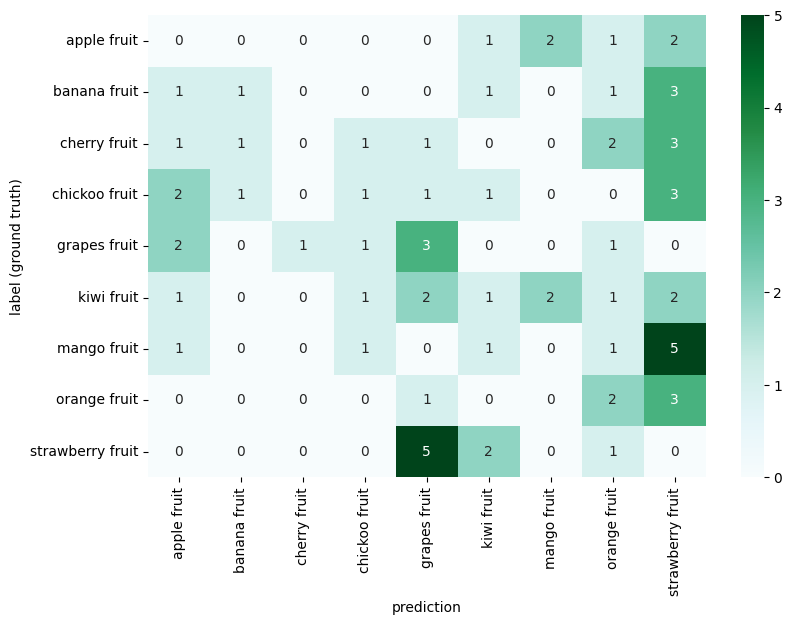

In [28]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val,1)[1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())
        correct += (predicted == y_test).sum()

arr = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [29]:
total_params = sum(p.numel() for p in VGG19model.parameters())
print(f'{total_params:,} total parameters.')

total_trainable_params = sum(
    p.numel() for p in VGG19model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

45,724,745 total parameters.
25,700,361 trainable parameters.


In [30]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
9216
9


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [32]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 287  # As per your dataset size
max_tst_batch = 72  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # X_train, y_train = X_train.to(device), y_train.to(device)

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1  batch: 21 loss: 4.4539 accuracy: 41.67%
epoch: 1  batch: 41 loss: 0.8904 accuracy: 52.44%
epoch: 1  batch: 61 loss: 5.3427 accuracy: 59.84%
epoch: 2  batch: 21 loss: 0.0114 accuracy: 85.71%
epoch: 2  batch: 41 loss: 7.7255 accuracy: 86.59%
epoch: 2  batch: 61 loss: 0.0285 accuracy: 85.66%
epoch: 3  batch: 21 loss: 0.1201 accuracy: 84.52%
epoch: 3  batch: 41 loss: 0.0000 accuracy: 89.63%
epoch: 3  batch: 61 loss: 0.0000 accuracy: 88.11%

Duration: 1225 seconds


In [33]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')


[tensor(59), tensor(65), tensor(62)]
Test accuracy: 86.111%


In [34]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

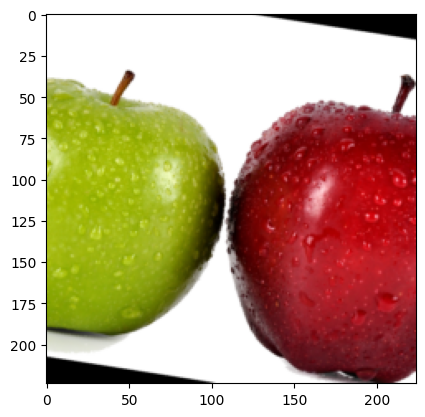

'apple fruit'

In [35]:
image_index = 16
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()

# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

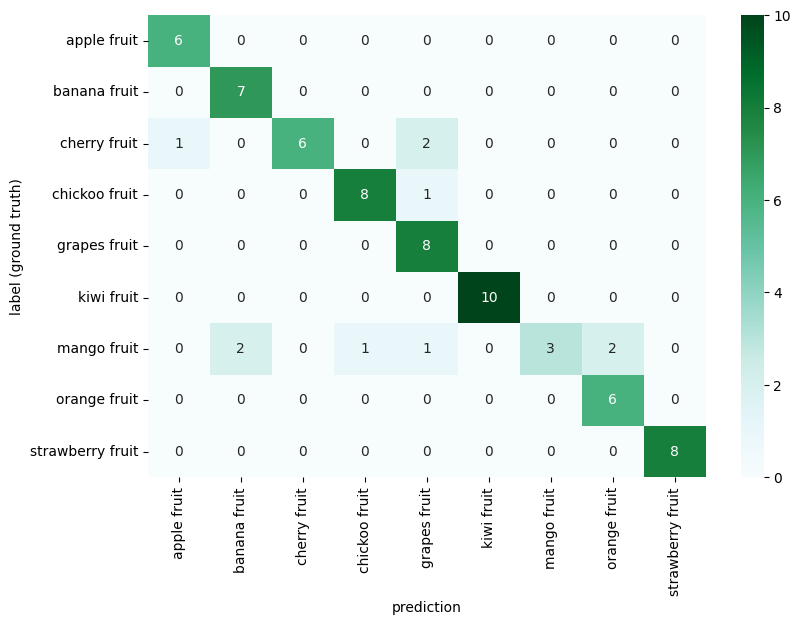

In [36]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val,1)[1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())
        correct += (predicted == y_test).sum()

arr = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.title("Confusion Matrix for Test Data")
plt.show();

In [37]:
!pip install torchsummary

from torchsummary import summary

# Assuming VGG19model is already defined
summary(VGG19model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

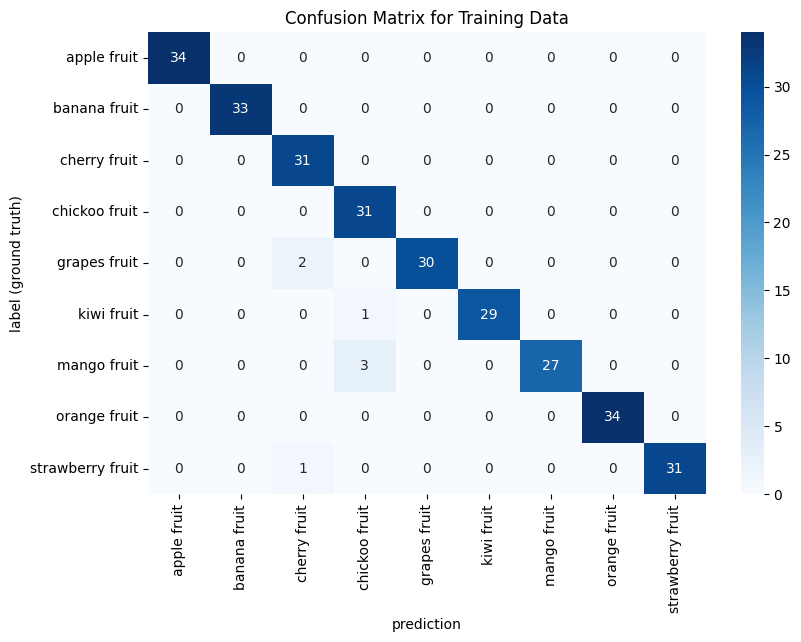

In [39]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Create a loader for the entire training set
train_load_all = DataLoader(train_data, batch_size=20, shuffle=False)

all_train_preds = []
all_train_labels = []
with torch.no_grad():
    for X_train, y_train in train_load_all:
        y_val = VGG19model(X_train)
        predicted = torch.max(y_val,1)[1]
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(y_train.cpu().numpy())

arr_train = confusion_matrix(all_train_labels, all_train_preds)
df_cm_train = pd.DataFrame(arr_train, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm_train, annot=True, fmt="d", cmap='Blues') # Using a different cmap for clarity
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.title("Confusion Matrix for Training Data")
plt.show();

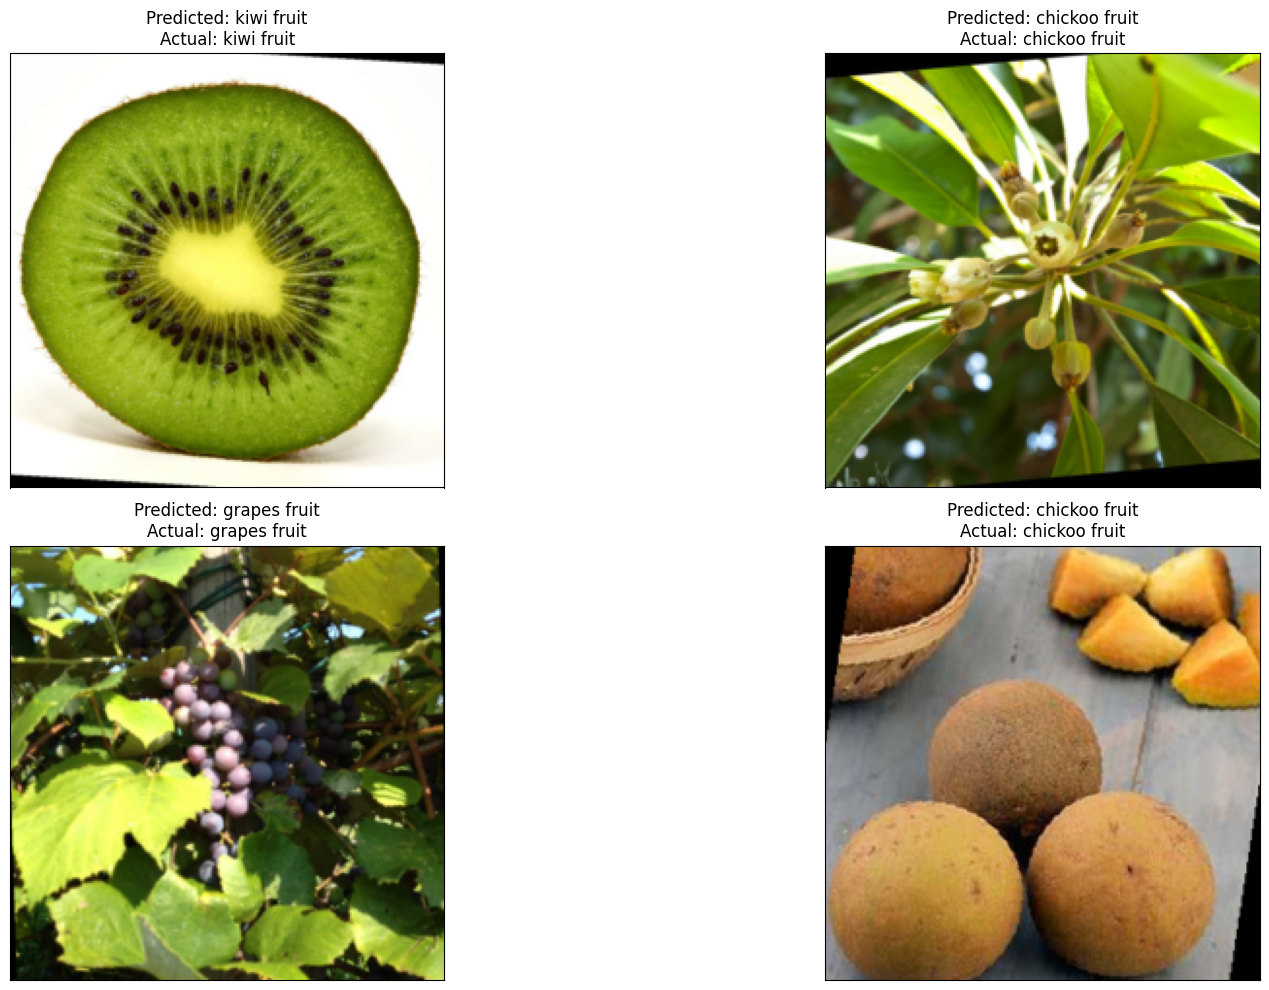

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming inv_normalize and test_loader are defined
# Assuming VGG19model is in evaluation mode

VGG19model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter) # Get the first batch
    images2, labels2 = next(dataiter) # Get the second batch

    # Concatenate images and labels from the first two batches to get more examples
    all_images = torch.cat((images, images2), dim=0)
    all_labels = torch.cat((labels, labels2), dim=0)

    # Get predictions for the combined batch
    outputs = VGG19model(all_images)
    _, predicted = torch.max(outputs, 1)

    # Display first 6 images and predictions horizontally (or fewer if batch size is small)
    num_images_to_display = min(len(all_images), 6) # Display up to 6 images
    fig = plt.figure(figsize=(20, 10))
    for i in range(num_images_to_display):
        ax = fig.add_subplot(2, num_images_to_display//2 + num_images_to_display%2, i + 1, xticks=[], yticks=[])
        # Inverse normalize and display the image
        img = inv_normalize(all_images[i])
        plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
        ax.set_title(f'Predicted: {class_names[predicted[i]]}\nActual: {class_names[all_labels[i]]}')

    plt.tight_layout()
    plt.show()